## Predicting TelCo Customer Churn - EDA

[Kaggle link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)

[Additional information about the dataset](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

### 1. Load packages and data

In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import seaborn as sns
from plotly import figure_factory as ff
from plotly.subplots import make_subplots

pd.set_option("display.float_format", lambda x: f"{x:.3f}")
warnings.filterwarnings("ignore")

# loading data
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

### 2. Discovery

##### 2a. According to the Kaggle data card:

- **Customers who left within the last month** – the column is called Churn
- **Services that each customer has signed up for** – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- **Customer account information** – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- **Demographic info about customers** – gender, age range, and if they have partners and dependents
 
- Additional details about the dataset found [here](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

##### 2b. Understanding the nature of the data - .nunique() and .unique()

In [2]:
for i in df.columns:
    print(df[i].nunique(), "\t", i, "        \t", sorted(df[i].unique())[:20])

7043 	 customerID         	 ['0002-ORFBO', '0003-MKNFE', '0004-TLHLJ', '0011-IGKFF', '0013-EXCHZ', '0013-MHZWF', '0013-SMEOE', '0014-BMAQU', '0015-UOCOJ', '0016-QLJIS', '0017-DINOC', '0017-IUDMW', '0018-NYROU', '0019-EFAEP', '0019-GFNTW', '0020-INWCK', '0020-JDNXP', '0021-IKXGC', '0022-TCJCI', '0023-HGHWL']
2 	 gender         	 ['Female', 'Male']
2 	 SeniorCitizen         	 [0, 1]
2 	 Partner         	 ['No', 'Yes']
2 	 Dependents         	 ['No', 'Yes']
73 	 tenure         	 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
2 	 PhoneService         	 ['No', 'Yes']
3 	 MultipleLines         	 ['No', 'No phone service', 'Yes']
3 	 InternetService         	 ['DSL', 'Fiber optic', 'No']
3 	 OnlineSecurity         	 ['No', 'No internet service', 'Yes']
3 	 OnlineBackup         	 ['No', 'No internet service', 'Yes']
3 	 DeviceProtection         	 ['No', 'No internet service', 'Yes']
3 	 TechSupport         	 ['No', 'No internet service', 'Yes']
3 	 StreamingTV         	

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors="coerce")

In [5]:
columns_to_drop = ["customerID"]

try:
    df = df.drop(columns=columns_to_drop)
except KeyError:
    pass

boolean_columns = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "PaperlessBilling",
    "Churn",
]

categorical_columns = [
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaymentMethod",
]

numerical_columns = ["tenure", "MonthlyCharges", "TotalCharges"]


if not (
    len(boolean_columns)
    + len(categorical_columns)
    + len(numerical_columns)
    - len(df.columns)
):
    print("Categorized all columns")
else:
    print("Check if you accounted for all columns")

Categorized all columns


Notes:
- Customers can have phone and/or internet services, and related services
- There are blank values in the column TotalCharges
- customerID seems to be a useless feature for predicting churn

##### 2c. Check data integrity - check for missing values and outliers

In [6]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Blanks in TotalCharges: attributable to customers with 0 months of tenure

In [7]:
df[df.TotalCharges == " "].tenure.describe()

count   0.000
mean      NaN
std       NaN
min       NaN
25%       NaN
50%       NaN
75%       NaN
max       NaN
Name: tenure, dtype: float64

Dropping this subset should be fine as they are (1) likely not helpful for predicting churn and (2) constitue a very small portion of the dataset, unlikely to affect the outcome significantly

In [8]:
df = df[df.tenure > 0]

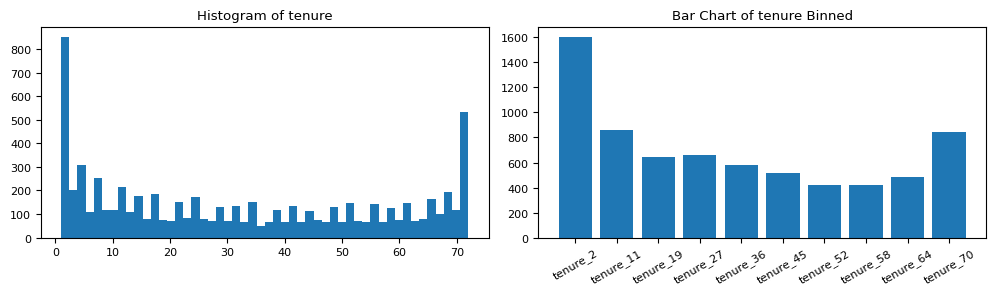

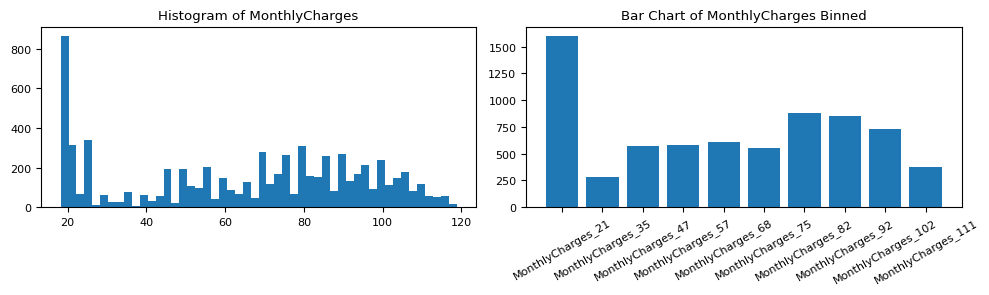

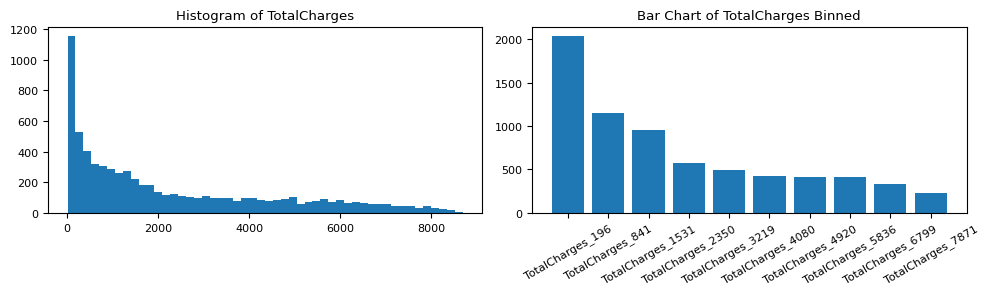

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_value,MonthlyCharges_value,TotalCharges_value
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,tenure_2,MonthlyCharges_35,TotalCharges_196
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,tenure_36,MonthlyCharges_57,TotalCharges_1531
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,tenure_2,MonthlyCharges_57,TotalCharges_196
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,tenure_45,MonthlyCharges_47,TotalCharges_1531
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,tenure_2,MonthlyCharges_68,TotalCharges_196


In [9]:
from sklearn.cluster import KMeans


def get_knn_bins(df, cols, bins=10, drop_cols=True):
    plt.rc("font", **{"size": 8})

    for col in cols:
        kmeans = KMeans(n_clusters=bins).fit(df[col].to_frame().values.reshape(-1, 1))
        results = pd.DataFrame(kmeans.labels_, columns=[col + "_centroid"])

        df = df.reset_index()
        df[col + "_centroid"] = results[col + "_centroid"]

        knn_bin_df = pd.DataFrame(kmeans.cluster_centers_)
        knn_bin_df = knn_bin_df.astype(int).reset_index()

        temp_df = pd.merge(
            df[col + "_centroid"],
            knn_bin_df,
            left_on=col + "_centroid",
            right_on="index",
            how="left",
        )

        temp_df = temp_df.rename(columns={0: col + "_value"})

        temp_df.loc[:, col + "_value"] = col + "_" + temp_df[col + "_value"].astype(str)

        df = pd.concat([df, temp_df[col + "_value"]], axis=1)
        df.drop([col + "_centroid", "index"], axis=1, inplace=True)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

        ax1.hist(df[col].values, bins=50)
        ax1.set_title("Histogram of " + col)

        Count_Bins = (
            temp_df[col + "_value"]
            .value_counts()
            .rename_axis("bins")
            .reset_index(name="counts")
        )
        extract_number = Count_Bins.bins.str.extract(
            "([a-zA-Z]+)([^a-zA-Z]+)", expand=True
        )
        extract_number.columns = ["Text", "Number"]
        Count_Bins["bin_centroid"] = (
            extract_number["Number"].apply(lambda x: x.split("_")[1]).astype(int)
        )
        Count_Bins.sort_values(by=["bin_centroid"], ascending=True, inplace=True)

        ax2.bar(Count_Bins.iloc[:, 0], Count_Bins.iloc[:, 1])
        ax2.set_title("Bar Chart of " + col + " Binned")
        ax2.tick_params(labelrotation=30)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    if drop_cols:
        return df.drop(cols, axis=1)

    else:
        return df


recoded_df = get_knn_bins(df, numerical_columns, bins=10)
recoded_df.head()

##### 2d. Understanding the nature of the data - TotalCharges

[Total Charges may include additional charges such as extra data and long distance](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113)

In [10]:
df_charges = df[["tenure", "MonthlyCharges", "TotalCharges"]].copy()
df_charges["CalcTotal"] = df_charges.tenure * df_charges.MonthlyCharges
df_charges["Delta"] = df_charges.TotalCharges - df_charges.CalcTotal
df_charges["DeltaPct"] = df_charges.Delta / df_charges.TotalCharges
# df_charges[df_charges.Delta == 0]
df_charges["DeltaPctAbs"] = df_charges.DeltaPct.abs()
df_charges.sort_values(by=["DeltaPct"]).head(50)
df_charges["MonthlyAvgDeltaPctAbs"] = (df_charges.Delta / df_charges.MonthlyCharges).abs()
df_charges.sort_values(by=["MonthlyAvgDeltaPctAbs"], ascending=False).head(50)
df_charges["AddlChargesPerMonth"] = df_charges.Delta / df_charges.tenure
df_charges.describe()

,tenure,MonthlyCharges,TotalCharges,CalcTotal,Delta,DeltaPct,DeltaPctAbs,MonthlyAvgDeltaPctAbs,AddlChargesPerMonth
count,7032.000,7032.000,7032.000,7032.000,7032.000,7032.000,7032.000,7032.000,7032.000
mean,32.422,64.798,2283.300,2283.147,0.153,-0.002,0.032,0.765,0.001
std,24.545,30.086,2266.771,2264.703,67.255,0.051,0.040,0.841,2.616
min,1.000,18.250,18.800,18.800,-370.850,-0.451,0.000,0.000,-19.125
25%,9.000,35.587,401.450,397.800,-28.650,-0.021,0.007,0.166,-1.148
50%,29.000,70.350,1397.475,1394.575,0.000,0.000,0.020,0.503,0.000
75%,55.000,89.862,3794.738,3791.250,28.700,0.019,0.042,1.082,1.160
max,72.000,118.750,8684.800,8550.000,373.250,0.364,0.451,7.707,18.900


### 3. EDA & Visualization

##### Helper functions

In [11]:
def create_value_counts_df(
    original_df: pd.DataFrame,
    column_names: list[str],
    common_mapping: dict,
    index_by_churn: bool,
    **custom_mapping_kwargs,
) -> pd.DataFrame:
    cols_to_map = column_names.copy()

    if "Churn" in column_names:
        cols_to_map.remove("Churn")

    map_df = original_df[cols_to_map].copy()

    custom_mapped_cols = []
    if custom_mapping_kwargs:
        for k, val in custom_mapping_kwargs.items():
            map_df[k] = map_df[k].map(val)
            custom_mapped_cols.append(k)
    for i in cols_to_map:
        if i not in custom_mapped_cols:
            map_df[i] = map_df[i].map(common_mapping)

    map_df = pd.concat([map_df, original_df.Churn], axis=1)

    value_counts = []
    if index_by_churn:
        idx = ["Retained", "Churned"]
        for i in cols_to_map:
            value_counts.append(
                map_df.groupby(by=["Churn", i]).size().unstack(fill_value=0)
            )
    else:
        idx = sorted(common_mapping.values())
        for i in cols_to_map:
            value_counts.append(
                map_df.groupby(by=[i, "Churn"]).size().unstack(fill_value=0)
            )
    out_df = pd.concat(value_counts, axis=1, keys=cols_to_map)
    out_df.index = idx
    out_df = out_df.stack(level=-1).T

    return out_df

In [12]:
def generate_grouped_stacked_bar_charts(
    df_vc: pd.DataFrame,
    index_by_churn: bool,
    label_dict: dict,
    color_dict: dict,
    export_path: str | None = None,
):
    """Reference: https://community.plotly.com/t/grouped-stacked-bar-chart/60805/5"""

    fig = go.Figure(
        layout=go.Layout(
            height=600,
            width=1000,
            barmode="relative",
            yaxis_showticklabels=False,
            yaxis_showgrid=False,
            yaxis_range=[0, df_vc.groupby(axis=1, level=0).sum().max().max() * 1.5],
            yaxis2=go.layout.YAxis(
                visible=False,
                matches="y",
                overlaying="y",
                anchor="x",
            ),
            yaxis3=go.layout.YAxis(
                visible=False, matches="y", overlaying="y", anchor="x"
            ),
            yaxis4=go.layout.YAxis(
                visible=False, matches="y", overlaying="y", anchor="x"
            ),
            font={"size": 12},
            hovermode="x",
            margin={"b": 10, "t": 10, "l": 10, "r": 10},
        )
    )

    churned_label = {"No": "Retained", "Yes": "Churned"}
    spacing = len(color_dict) * 1.5

    for i, t in enumerate(color_dict):
        for col in df_vc[t].columns:
            if (df_vc[t][col] == 0).all():
                continue
            fig.add_bar(
                x=df_vc.index,
                y=df_vc[t][col],
                yaxis=f"y{i + 1}",
                offsetgroup=str(i),
                offset=(i - 1) * 1 / spacing,
                width=1 / spacing,
                text=[
                    f"{t},<br>{label_dict[feature][col]},<br>{i:.0f}%"
                    for feature, i in (df_vc[t][col] / df_vc[t].sum(axis=1) * 100).items()
                ]
                if index_by_churn
                else [
                    f"{label_dict[feature][t]},<br>{churned_label[col]}<br>{i:.0f}%"
                    for feature, i in (df_vc[t][col] / df_vc[t].sum(axis=1) * 100).items()
                ],
                textfont={"size": 8},
                name=col,
                marker_color=color_dict[t][col],
                hovertemplate="%{y}<extra></extra>",
            )

    fig.add_annotation()

    if export_path:
        fig.write_image(f"data/{export_path}")

    fig.show()

### 3a. Visualizing distributions (with regards to Churn)

##### 3a-i. Distribution of binary variables

In [ ]:
binary_vc = create_value_counts_df(
    original_df=df,
    column_names=boolean_columns,
    common_mapping={"No": 0, "Yes": 1},
    index_by_churn=True,
    gender={"Female": 0, "Male": 1},
)

colors = {
    "Retained": {
        0: "#F28F1D",
        1: "#FADD75",
    },
    "Churned": {
        0: "#2B6045",
        1: "#9ED4B9",
    },
}

feature_label = {
    "gender": {0: "Female", 1: "Male"},
    "SeniorCitizen": {0: "Not Senior", 1: "Senior"},
    "Partner": {0: "Single", 1: "Partnered"},
    "Dependents": {0: "No Deps.", 1: "Has Deps."},
    "PhoneService": {0: "No Phone", 1: "Yes Phone"},
    "PaperlessBilling": {0: "Mailed", 1: "Paperless"},
}

generate_grouped_stacked_bar_charts(
    df_vc=binary_vc,
    index_by_churn=True,
    label_dict=feature_label,
    color_dict=colors,
    export_path="bool_churn.webp",
)

![test](data/bool_churn.webp)

In [ ]:
binary_vc = create_value_counts_df(
    original_df=df,
    column_names=boolean_columns,
    common_mapping={"No": 0, "Yes": 1},
    index_by_churn=False,
    gender={"Female": 0, "Male": 1},
)

colors = {
    0: {
        "No": "#F28F1D",
        "Yes": "#FADD75",
    },
    1: {
        "No": "#2B6045",
        "Yes": "#9ED4B9",
    },
}

generate_grouped_stacked_bar_charts(
    df_vc=binary_vc,
    index_by_churn=False,
    label_dict=feature_label,
    color_dict=colors,
    export_path="bool_feature.webp",
)

![test](data/bool_feature.webp)

##### 3a-ii. Distribution of internet service related features

In [16]:
internet_svc = categorical_columns.copy()
internet_svc.remove("MultipleLines")
internet_svc.remove("PaymentMethod")
internet_svc.remove("InternetService")
internet_svc.remove("Contract")

In [ ]:
tri_vc = create_value_counts_df(
    original_df=df,
    column_names=internet_svc,
    common_mapping={"No internet service": 2, "No": 0, "Yes": 1},
    index_by_churn=True,
)

colors = {
    "Retained": {0: "#F28F1D", 1: "#FADD75", 2: "grey"},
    "Churned": {0: "#2B6045", 1: "#9ED4B9", 2: "darkgrey"},
}

subfeature = {2: "No internet", 0: "No", 1: "Yes"}

feature_label = {
    "OnlineSecurity": subfeature,
    "OnlineBackup": subfeature,
    "DeviceProtection": subfeature,
    "TechSupport": subfeature,
    "StreamingTV": subfeature,
    "StreamingMovies": subfeature,
}

generate_grouped_stacked_bar_charts(
    df_vc=tri_vc,
    index_by_churn=True,
    label_dict=feature_label,
    color_dict=colors,
    export_path="int_churn.webp",
)

![test](data/int_churn.webp)

In [ ]:
tri_vc = create_value_counts_df(
    original_df=df,
    column_names=internet_svc,
    common_mapping={"No internet service": 2, "No": 0, "Yes": 1},
    index_by_churn=False,
)

colors = {
    0: {
        "No": "#F6C619",
        "Yes": "#FADD75",
    },
    1: {
        "No": "#5EB88A",
        "Yes": "#9ED4B9",
    },
    2: {"No": "grey", "Yes": "darkgrey"},
}

generate_grouped_stacked_bar_charts(
    df_vc=tri_vc,
    index_by_churn=False,
    label_dict=feature_label,
    color_dict=colors,
    export_path="int_feature.webp",
)

![test](data/int_feature.webp)

Observations:

- OnlineSecurity+TechSupport and OnlineBackup+DeviceProtection - Customers with additional support + security features less likely to churn

- StreamingTV+StreamingMovies - No noticeable difference in churn rate by streaming service subscriptions

##### 3a-iii. Distribution of other 'trinary' variables - Multiple [phone] lines, internet service type, contract

In [ ]:
other_tri_cols = ["MultipleLines", "InternetService", "Contract"]
is_map = {"No": 2, "DSL": 0, "Fiber optic": 1}
ml_map = {"No phone service": 2, "No": 0, "Yes": 1}
c_map = {"Month-to-month": 0, "One year": 1, "Two year": 2}

other_tri_vc = create_value_counts_df(
    original_df=df,
    column_names=other_tri_cols,
    common_mapping=is_map,
    index_by_churn=False,
    MultipleLines=ml_map,
    Contract=c_map,
)

colors = {
    0: {
        "No": "#F6C619",
        "Yes": "#FADD75",
    },
    1: {
        "No": "#5EB88A",
        "Yes": "#9ED4B9",
    },
    2: {"No": "grey", "Yes": "darkgrey"},
}

is_rev = {v: k for k, v in is_map.items()}
ml_rev = {v: k for k, v in ml_map.items()}
c_rev = {v: k for k, v in c_map.items()}


feature_label = {"InternetService": is_rev, "MultipleLines": ml_rev, "Contract": c_rev}

generate_grouped_stacked_bar_charts(
    df_vc=other_tri_vc,
    index_by_churn=False,
    label_dict=feature_label,
    color_dict=colors,
    export_path="tri_churn.webp",
)

![test](data/tri_churn.webp)

In [ ]:
other_tri_cols = ["MultipleLines", "InternetService", "Contract"]
is_map = {"No": 2, "DSL": 0, "Fiber optic": 1}
ml_map = {"No phone service": 2, "No": 0, "Yes": 1}
c_map = {"Month-to-month": 0, "One year": 1, "Two year": 2}

other_tri_vc = create_value_counts_df(
    original_df=df,
    column_names=other_tri_cols,
    common_mapping=is_map,
    index_by_churn=True,
    MultipleLines=ml_map,
    Contract=c_map,
)

colors = {
    "Retained": {0: "#F28F1D", 1: "#FADD75", 2: "grey"},
    "Churned": {0: "#2B6045", 1: "#9ED4B9", 2: "darkgrey"},
}

generate_grouped_stacked_bar_charts(
    df_vc=other_tri_vc,
    index_by_churn=True,
    label_dict=feature_label,
    color_dict=colors,
    export_path="tri_feature.webp",
)

![test](data/tri_feature.webp)

Observations:
- Fiber optics users among internet service customers more likely to churn
- Shorter contracts more likely to churn
- No noticeable difference between different phone service customers in re churn

##### 3a-iv. Distribution of PaymentMethod features

In [ ]:
pmt_cols = ["PaymentMethod"]
mappings = {
    "Electronic check": 0,
    "Mailed check": 1,
    "Bank transfer (automatic)": 2,
    "Credit card (automatic)": 3,
}

pmt_vc = create_value_counts_df(
    original_df=df,
    column_names=pmt_cols,
    common_mapping=mappings,
    index_by_churn=False,
)

colors = {
    0: {
        "No": "#F6C619",
        "Yes": "#FADD75",
    },
    1: {
        "No": "#5EB88A",
        "Yes": "#9ED4B9",
    },
    2: {"No": "grey", "Yes": "darkgrey"},
    3: {"No": "maroon", "Yes": "brown"},
}

feature_label = {"PaymentMethod": {y: x for x, y in mappings.items()}}

generate_grouped_stacked_bar_charts(
    df_vc=pmt_vc,
    index_by_churn=False,
    label_dict=feature_label,
    color_dict=colors,
    export_path="pmt_method.webp",
)

![test](data/pmt_method.webp)

Observation:
- Customers paying via electronic checks, strangely, more likely to churn?

##### 3a-v. Distribution of numerical columns

In [ ]:
fig = ff.create_distplot(
    hist_data=[df[df.Churn == "No"].MonthlyCharges, df[df.Churn == "Yes"].MonthlyCharges],
    group_labels=["Retained", "Churned"],
    bin_size=5,
    show_hist=False,
)
fig.update_layout(hovermode=False)
fig.write_image("data/mc_dist.webp")
fig.show()

![test](data/mc_dist.webp)

In [ ]:
fig = ff.create_distplot(
    hist_data=[df[df.Churn == "No"].TotalCharges, df[df.Churn == "Yes"].TotalCharges],
    group_labels=["Retained", "Churned"],
    show_hist=False,
)
fig.update_layout(hovermode=False)
fig.write_image("data/tc_dist.webp")
fig.show()

![test](data/tc_dist.webp)

In [ ]:
fig = ff.create_distplot(
    hist_data=[df[df.Churn == "No"].tenure, df[df.Churn == "Yes"].tenure],
    group_labels=["Retained", "Churned"],
    bin_size=5,
    show_hist=False,
)
fig.update_layout(hovermode=False)
fig.write_image("data/ten_dist.webp")
fig.show()

![test](data/ten_dist.webp)

Observations:
- Higher rate of churn at the higher end of price range, and vice versa
- Higher rate of churn at the shorter end of tenure range

### 3b. Multicolinearity

In [25]:
all_categorical_columns = categorical_columns + boolean_columns
cat_cat_prod = list(product(all_categorical_columns, all_categorical_columns, repeat=1))
cat_num_prod = list(product(all_categorical_columns, numerical_columns, repeat=1))
num_num_prod = list(product(numerical_columns, numerical_columns, repeat=1))

<Axes: xlabel='var2', ylabel='var1'>

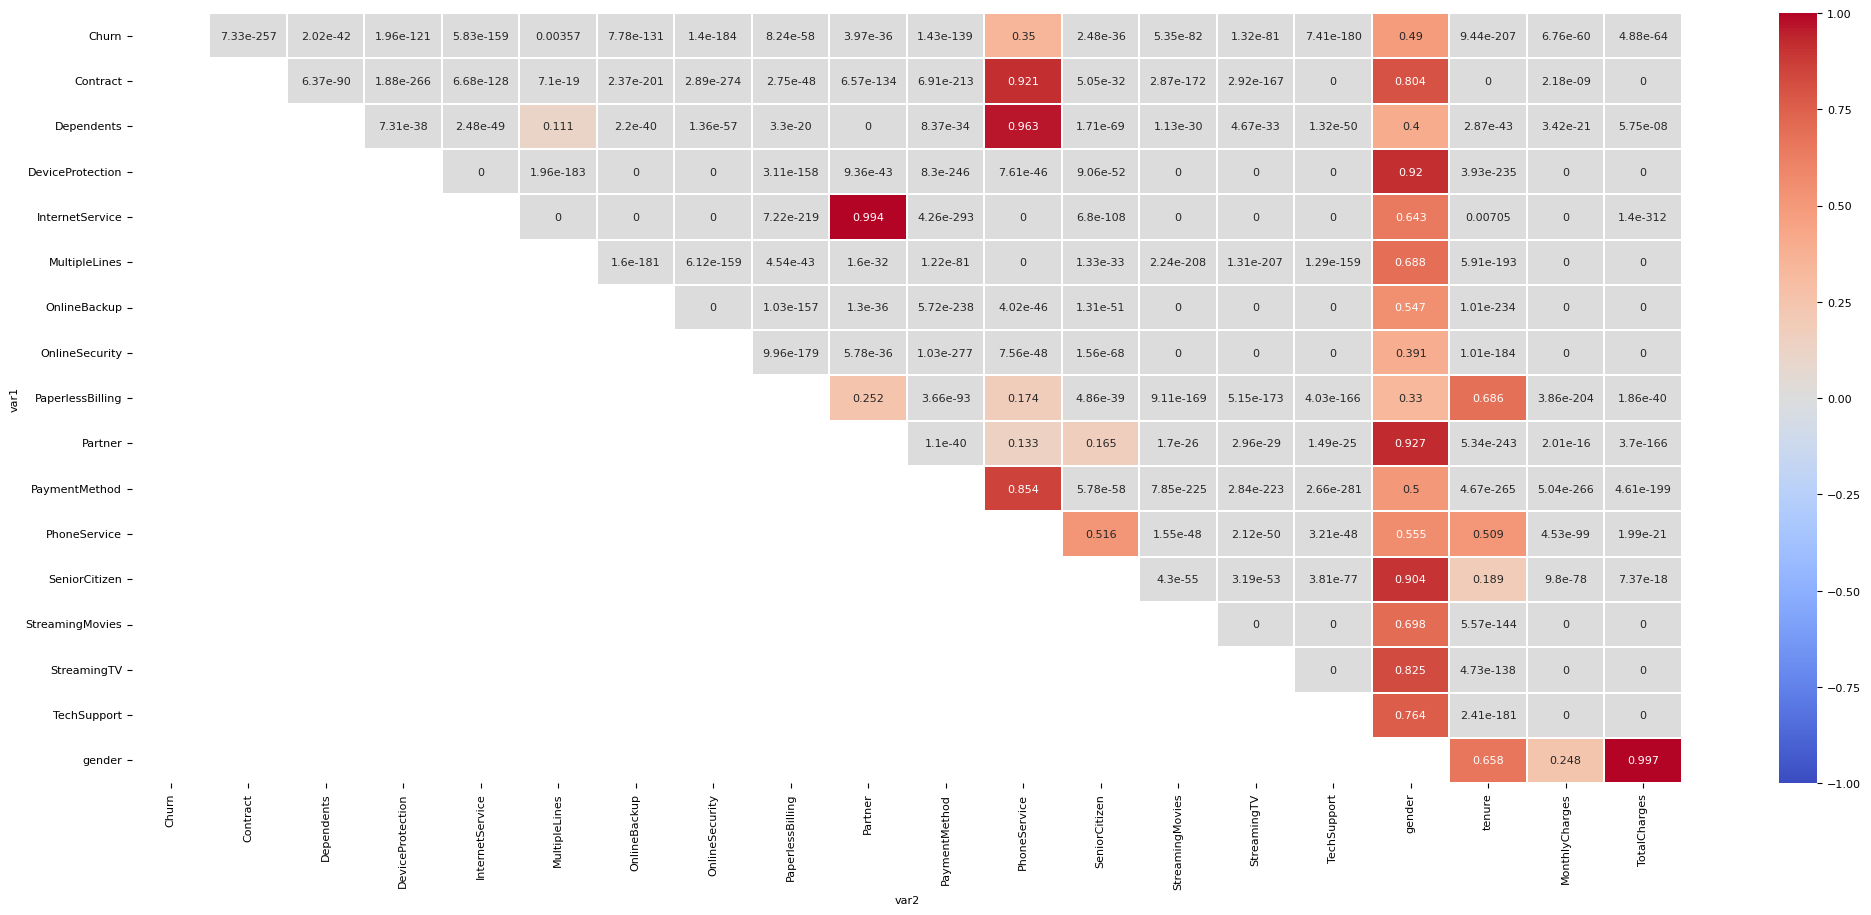

In [26]:
cat_corrs = []

for i in cat_cat_prod:
    if i[0] != i[1]:
        cat_corrs.append(
            [i[0], i[1], list(stats.chi2_contingency(pd.crosstab(df[i[0]], df[i[1]])))[1]]
        )

for i in cat_num_prod:
    if i[0] != i[1]:
        cat_corrs.append(
            [i[0], i[1], stats.f_oneway(*df.groupby(i[0])[i[1]].apply(list))[1]]
        )

df_cat_corrs = pd.DataFrame(cat_corrs, columns=["var1", "var2", "coeff"])

df_cat_corrs = df_cat_corrs.pivot(index="var1", columns="var2", values="coeff")

rearranged_columns = list(df_cat_corrs.columns)
rearranged_columns.remove("MonthlyCharges")
rearranged_columns.remove("TotalCharges")
rearranged_columns = rearranged_columns + ["MonthlyCharges", "TotalCharges"]

df_cat_corrs = df_cat_corrs[rearranged_columns]

mask = np.tril(np.ones_like(df_cat_corrs, dtype=bool))

plt.figure(figsize=(25, 10))

sns.heatmap(
    data=df_cat_corrs,
    mask=mask,
    xticklabels=df_cat_corrs.columns,
    yticklabels=df_cat_corrs.index,
    annot=True,
    linewidths=0.2,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    fmt=".3g",
)

Note:
- If p-values of Chi-squared and ANOVA one-way tests are low, we would reject the null hypothesis that two variables are not correlated
    - In other words, most variables herein are intercorrelated implied by the near-zero coefficients
    - The high coefficient (not correlated) for Dependents X MultipleLines is somewhat unexpected

- Notably, gender does not seem to correlate anywhere, though the lack of correlation vs. Churn was somewhat expected from the visualization above
    - Models will be trained without this feature

- Though the features specific to internet subscribers (e.g. StreamingTV) and phone subscribers (e.g. MultipleLines) are not necessarily one-to-one with the subscriptions, these features will be excluded from model training as they carry somewhat of "duplicate" information as seen in the coefficients of 0

In [27]:
num_corrs = []
for i in num_num_prod:
    if i[0] != i[1]:
        num_corrs.append([i[0], i[1], np.corrcoef(df[i[0]], df[i[1]])[0][1]])

df_num_corrs = pd.DataFrame(num_corrs, columns=["v1", "v2", "coefficient"])
df_num_corrs = df_num_corrs.pivot(index="v1", columns="v2", values="coefficient")
df_num_corrs

v2,MonthlyCharges,TotalCharges,tenure
v1,,,
MonthlyCharges,NaN,0.651,0.247
TotalCharges,0.651,NaN,0.826
tenure,0.247,0.826,NaN


Note:
- TotalCharges is largely a product of tenure and MonthlyCharges, so it may be an excess variable

### 4. Data transformation

Main dataset for model training will be a one hot encoded dataframe without the "duplicate" columns and without gender.

In [28]:
df_deduped_columns = [
    i for i in df.columns if i not in internet_svc + ["MultipleLines", "TotalCharges"]
]
df_deduped = df[[i for i in df_deduped_columns if i not in numerical_columns]]

deduped_cat_dummies = pd.get_dummies(df_deduped, drop_first=True, dtype=int)
df_deduped_one_hot = pd.concat([df[numerical_columns], deduped_cat_dummies], axis=1)

df_deduped_one_hot.to_csv("data/df_deduped.csv", index=False)

Backup dataset for model training - one hot encoding for all categorical variables

In [29]:
all_cat_dummies = pd.get_dummies(df[all_categorical_columns], drop_first=True, dtype=int)
df_all_one_hot = pd.concat([df[numerical_columns], all_cat_dummies], axis=1)

df_all_one_hot.to_csv("data/df_all.csv", index=False)